In [1]:
pip install datasets transformers --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.3.3.83 which is incompatible.
torch 2.5.1+cu124 requires nvidia-curand-cu12==10.3.5.147; platform_system == "Linux" and platform_machin

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

2025-04-11 22:08:17.069827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744409297.324359      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744409297.394435      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
IMG_SIZE = (224, 224)
NUM_CLASSES = 1

In [4]:
dir1 = "/kaggle/input/bnreel/Video/Video"
dir2 = "/kaggle/input/bnreel/UNBER_IG/UNBER_IG/Video_IG"

In [5]:
def load_video_frames(video_folder):
    frames = []
    frame_files = sorted(os.listdir(video_folder))
    for file in frame_files:
        img_path = os.path.join(video_folder, file)
        img = load_img(img_path, target_size=IMG_SIZE)
        img = img_to_array(img)
        frames.append(img)

    return np.array(frames)

In [6]:
TEXT_CSV = "/kaggle/input/bnreel/BNREEL_text.csv"

In [7]:
import pandas as pd
tdf = pd.read_csv(TEXT_CSV)

In [8]:
tdf

,file_id,class,text,source,category
0,1000188341415358,Safe,Me on my way to watch Oppenheimer After Berbie,Facebook,Safe
1,1006146964533997,Safe,[NULL],Facebook,Safe
2,1007123741459823,Adult,বান্ধবী আমার লাগানির পিনিকে আছে Love in love,Facebook,Unsafe
3,1007420607202244,Safe,প্রত্যেকটা অফিসে এমন একজন কলিগ থাকবেই Laptop,Facebook,Safe
4,1008519870870927,Safe,হ্যালো শার্ক ট্যাঙ্ক বাংলাদেশ আই এম কামিং,Facebook,Safe
...,...,...,...,...,...
1916,3356285208118215619_62841927222,Safe,The amount of comfort this scene gives >>,Instagram,Safe
1917,3363424170779680862_62841927222_2,Safe,Anupam Roy's voice is line medicine for all br...,Instagram,Safe
1918,3363424170779680862_62841927222_3,Safe,Anupam Roy's voice is line medicine for all br...,Instagram,Safe
1919,3363424170779680862_62841927222_,Safe,Anupam Roy's voice is line medicine for all br...,Instagram,Safe


In [9]:
tdf['category'].value_counts()

category
Unsafe    1064
Safe       857
Name: count, dtype: int64

In [10]:
tdf['category'], uniques = pd.factorize(tdf['category'])
uniques

Index(['Safe', 'Unsafe'], dtype='object')

In [11]:
X_video, y = [], []

In [12]:
for _, row in tdf.iterrows():
    reel_id = row["file_id"] 
    label = row["category"]  

    for dir in [dir1, dir2]:
        video_folder = os.path.join(dir, reel_id)
        if os.path.isdir(video_folder):
            frames = load_video_frames(video_folder)

            # Fix the frame count to exactly 15
            if frames.shape[0] < 10:
                # Pad with last frame
                pad_count = 10 - frames.shape[0]
                last_frame = frames[-1:]
                pad_frames = np.repeat(last_frame, pad_count, axis=0)
                frames = np.concatenate([frames, pad_frames], axis=0)
            elif frames.shape[0] > 10:
                # Truncate extra frames
                frames = frames[:10]

            if frames.shape == (10, 224, 224, 3):
                X_video.append(frames)
                y.append(label)
            else:
                print(reel_id, "Shape mismatch:", frames.shape)

In [13]:
X_video = np.array(X_video)  
y = np.array(y)

In [14]:
print(X_video.shape)
print(y.shape)

(1916, 10, 224, 224, 3)
(1916,)


In [15]:
X_train_vid, X_temp, y_train, y_temp = train_test_split(X_video, y, test_size=0.2, random_state=42, stratify=y)
X_val_vid, X_test_vid, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [16]:
print(X_train_vid.shape)
print(X_val_vid.shape)
print(X_test_vid.shape)

(1532, 10, 224, 224, 3)
(192, 10, 224, 224, 3)
(192, 10, 224, 224, 3)


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import ResNetModel, AutoImageProcessor

In [18]:
model_name_or_path = "microsoft/resnet-50"
feature_extractor = AutoImageProcessor.from_pretrained(model_name_or_path)

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [19]:
resnet_model = ResNetModel.from_pretrained(model_name_or_path)
resnet_model.eval()

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

ResNetModel(
  (embedder): ResNetEmbeddings(
    (embedder): ResNetConvLayer(
      (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (encoder): ResNetEncoder(
    (stages): ModuleList(
      (0): ResNetStage(
        (layers): Sequential(
          (0): ResNetBottleNeckLayer(
            (shortcut): ResNetShortCut(
              (convolution): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (normalization): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (layer): Sequential(
              (0): ResNetConvLayer(
                (convolution): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
                (normalizatio

In [20]:
import torch.nn as nn
import torch

class ResNet_LSTM_Model(nn.Module):
    def __init__(self, resnet_model, lstm_hidden_size=512, dropout=0.3):
        super(ResNet_LSTM_Model, self).__init__()
        self.vit = resnet_model
        self.lstm_hidden_size = lstm_hidden_size

        for name, param in self.vit.named_parameters():
            if "encoder.layer.10" in name or "encoder.layer.11" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        self.lstm = nn.LSTM(input_size=49, hidden_size=lstm_hidden_size, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.bn = nn.BatchNorm1d(lstm_hidden_size)
        self.fc = nn.Linear(lstm_hidden_size, 1)

    def forward(self, x):
        batch_size, num_frames, c, h, w = x.shape
        x = x.view(batch_size * num_frames, c, h, w)

        with torch.no_grad():
            vit_out = self.vit(x).last_hidden_state[:, 0, :]  # CLS token

        features = vit_out.view(batch_size, num_frames, -1)

        lstm_out, _ = self.lstm(features)
        final_feature = lstm_out[:, -1, :]  # (batch, hidden)

        final_feature = self.dropout(final_feature)
        final_feature = self.bn(final_feature)

        return self.fc(final_feature)  # (batch, 1)

In [21]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [22]:
class VideoDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        video = self.X[idx]  # Shape: (num_frames, 224, 224, 3)
        label = self.y[idx]

        # Convert to tensor and normalize
        video = torch.tensor(video, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0  # (num_frames, 3, 224, 224)
        return video, torch.tensor(label, dtype=torch.long)

In [23]:
train_dataset = VideoDataset(X_train_vid, y_train)
val_dataset = VideoDataset(X_val_vid, y_val)
test_dataset = VideoDataset(X_test_vid, y_test)

In [24]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet_LSTM_Model(resnet_model).to(device)

In [29]:
criterion = nn.BCEWithLogitsLoss()

In [30]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.5, verbose=True)

In [31]:
num_epochs = 50
best_f1 = 0
patience = 3
counter = 0

In [32]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for videos, labels in train_loader:
        videos, labels = videos.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(videos)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for videos, labels in val_loader:
            videos, labels = videos.to(device), labels.to(device).float().unsqueeze(1)

            outputs = model(videos)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = (torch.sigmoid(outputs) > 0.5).int().squeeze()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().squeeze().numpy())

    avg_val_loss = val_loss / len(val_loader)
    f1 = f1_score(all_labels, all_preds)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val F1: {f1:.4f}")

    scheduler.step(f1)

    if f1 > best_f1:
        best_f1 = f1
        counter = 0
        torch.save(model.state_dict(), 'resnet_lstm_h1.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/50] | Train Loss: 0.7245 | Val Loss: 0.6877 | Val F1: 0.6276
Epoch [2/50] | Train Loss: 0.7141 | Val Loss: 0.6919 | Val F1: 0.6741
Epoch [3/50] | Train Loss: 0.7152 | Val Loss: 0.7086 | Val F1: 0.6250
Epoch [4/50] | Train Loss: 0.7143 | Val Loss: 0.6922 | Val F1: 0.6446
Epoch [5/50] | Train Loss: 0.6923 | Val Loss: 0.7021 | Val F1: 0.6909
Epoch [6/50] | Train Loss: 0.7086 | Val Loss: 0.7071 | Val F1: 0.6349
Epoch [7/50] | Train Loss: 0.6918 | Val Loss: 0.6899 | Val F1: 0.6792
Epoch [8/50] | Train Loss: 0.6886 | Val Loss: 0.6873 | Val F1: 0.6940
Epoch [9/50] | Train Loss: 0.6945 | Val Loss: 0.6909 | Val F1: 0.6614
Epoch [10/50] | Train Loss: 0.6924 | Val Loss: 0.6842 | Val F1: 0.6870
Epoch [11/50] | Train Loss: 0.6768 | Val Loss: 0.6965 | Val F1: 0.6667
Early stopping triggered.


In [33]:
# torch.save(model.state_dict(), "vit_lstm_h1.pth")  

In [34]:
from sklearn.metrics import classification_report

In [35]:
model.eval()
all_preds, all_labels = [], []

In [36]:
with torch.no_grad():
    for videos, labels in test_loader:
        videos, labels = videos.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(videos)

        preds = (torch.sigmoid(outputs) > 0.5).int().cpu().squeeze().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().squeeze().numpy())

In [37]:
print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

         0.0     0.5714    0.1395    0.2243        86
         1.0     0.5673    0.9151    0.7004       106

    accuracy                         0.5677       192
   macro avg     0.5693    0.5273    0.4623       192
weighted avg     0.5691    0.5677    0.4871       192



In [38]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

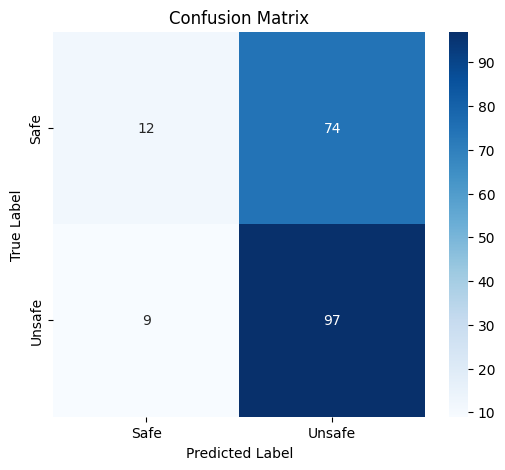

In [39]:
class_names = ['Safe', 'Unsafe']  
plot_confusion_matrix(all_labels, all_preds, class_names)